In [2]:
import os
import sys
main_folder_path = os.path.abspath('..')
sys.path.append(main_folder_path)
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-k8fr8hgo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-k8fr8hgo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=fa0756546bd50d81c9f966e7502eae6bbaeb05179399fd8a2b7d7d513b4ab0f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-4le_w2o2/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [4]:
!git clone https://github.com/DWalicki95/MaterialsVision.git

Cloning into 'MaterialsVision'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 52 (delta 21), reused 23 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 267.73 KiB | 29.75 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [5]:
%cd MaterialsVision

/content/MaterialsVision


In [6]:
device = "cuda"

<H2> Wybór danych do analizy <H2>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from materials_vision.data_loader import DataLoader

Wczytuje ściezki do danych w Google Drive


In [10]:
magnification = 40
data_loader = DataLoader('AS')
data = data_loader.keep_magnification(magnification)

In [21]:
def show_random_img(data: dict, subseries_name: str, show:bool = True, random_seed=42):
    if random_seed > -1:
        np.random.seed(random_seed)
    images_paths = data[subseries_name]
    rand_img = np.random.choice(images_paths)
    rand_img = cv2.imread(rand_img)
    if show:
        plt.imshow(rand_img)
        plt.axis('off')
        print(rand_img.shape)
    return rand_img

In [12]:
def crop_image(img, height_after_cropping: int = 960):
    return img[0:height_after_cropping]

(1040, 1280, 3)


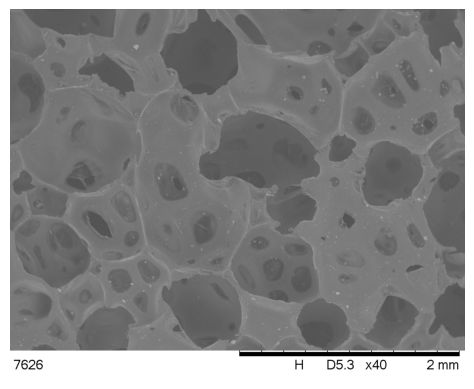

In [25]:
img = show_random_img(data, 'AS3', random_seed=-1)

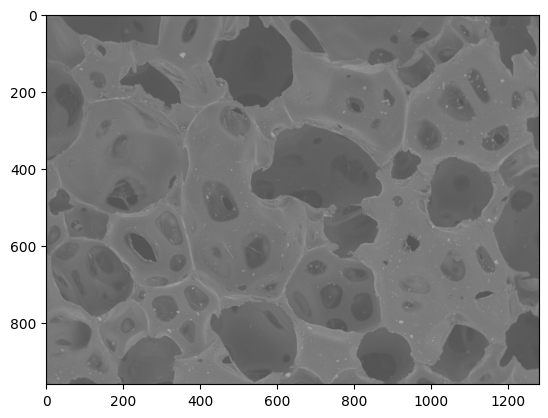

In [26]:
cropped_img = crop_image(img)
plt.imshow(cropped_img)

<H1> Automatically generating masks

In [27]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from materials_vision.config import SAM_VIT_B_WEIGHTS

In [28]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [29]:
def show_masks(masks, img):
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    show_anns(masks)
    plt.axis('off')
    plt.show()

<H2> ViT_B </H2>

In [30]:
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=SAM_VIT_B_WEIGHTS)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

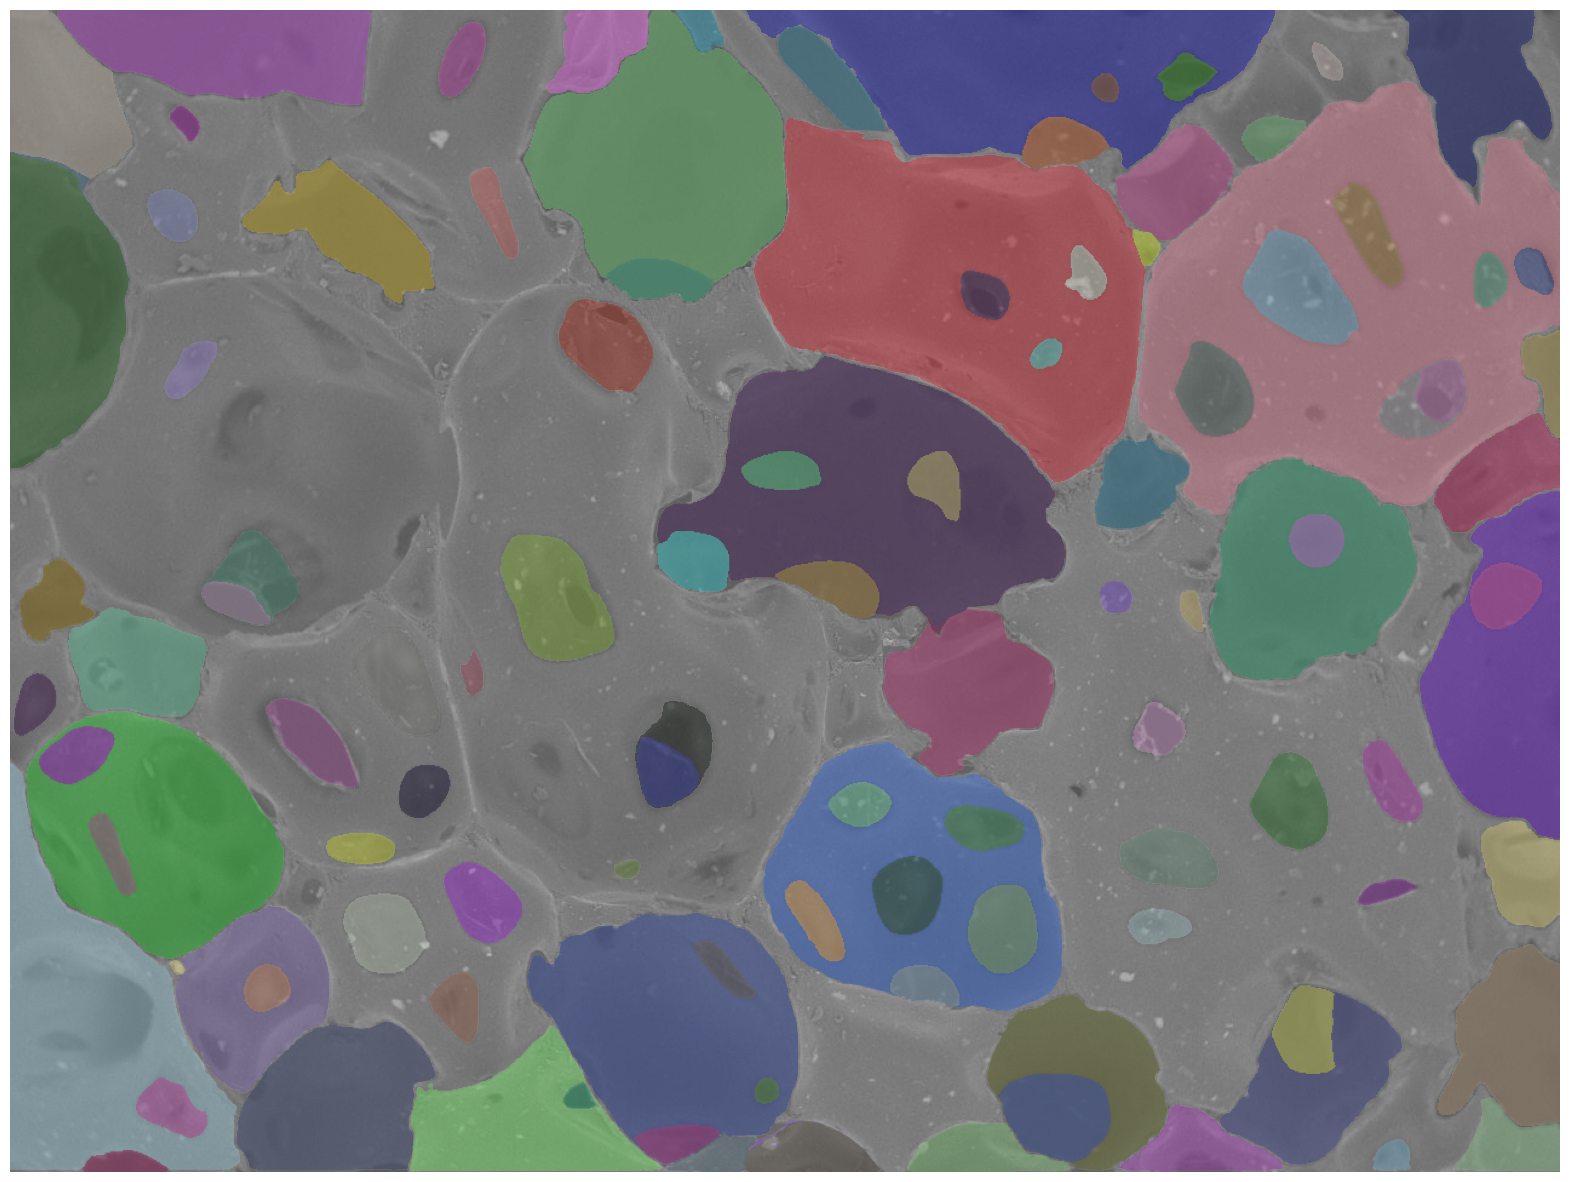

In [31]:
masks = mask_generator.generate(cropped_img)
show_masks(masks, cropped_img)